In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from PIL import Image 
import numpy as np

In [2]:
X, y = load_digits(return_X_y=True)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define a custom dataset
class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    
split = int(len(X_tensor) * 0.8)
# Create train and test datasets
train_dataset = DigitsDataset(X_tensor[:split], y_tensor[:split])
X_test, y_test = X_tensor[split:], y_tensor[split:]

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [3]:
# Define model
class FF(nn.Module):
    def __init__(self):
        super(FF, self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,10)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
model = FF()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

train_losses = []
train_accs = []
test_losses = []
test_accs = []

In [4]:
# Training
n_epochs = 200

progress_bar = tqdm(range(n_epochs))

for epoch in progress_bar:
    train_loss = 0.0
    train_correct = 0
    model.train()
    
    
    for X_train, y_train in train_loader:
        optimizer.zero_grad()
        
        pred = model(X_train)
        
        loss = F.cross_entropy(pred, y_train)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += sum(torch.max(pred, 1)[1] == y_train).item()
        
    train_accuracy = train_correct / len(train_dataset)
    train_accs.append(train_accuracy)
    train_losses.append(train_loss)
    
    # Testing
    model.eval()

    with torch.no_grad():
        pred = model(X_test)
        test_loss = F.cross_entropy(pred, y_test)
        test_accuracy = sum(torch.max(pred, 1)[1] == y_test) / len(y_test)

        test_losses.append(test_loss)
        test_accs.append(test_accuracy)
        
    progress_bar.set_description(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%") 

Train Loss: 4.7513, Train Acc: 0.96%, Test Acc: 0.91%: 100%|█████████████████████████| 200/200 [00:35<00:00,  5.71it/s]


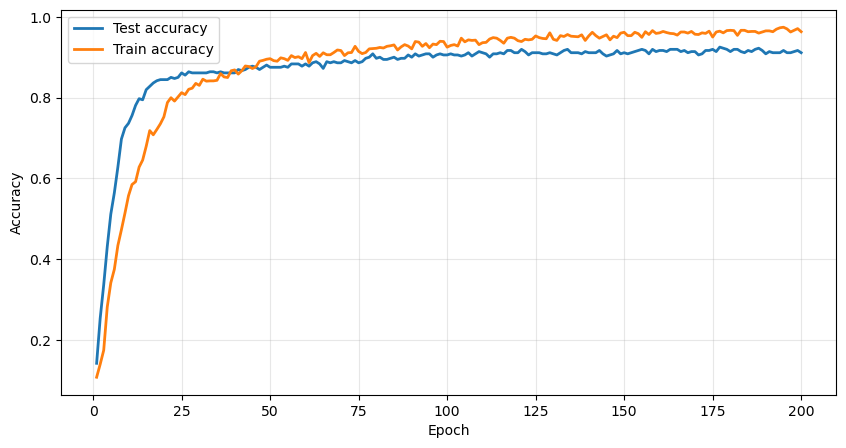

In [5]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ln2 = plt.plot(range(1,len(test_accs)+1), test_accs, label='Test accuracy', linewidth=2)
ln1 = plt.plot(range(1,len(train_accs)+1), train_accs, label='Train accuracy', linewidth=2)

ax.legend()

plt.grid(True, alpha=0.3)
plt.savefig('88mnist_training.png', transparent=False, bbox_inches='tight') 

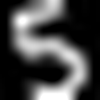

In [6]:
def display_digit(data, target_size=100, index=None):
    img = Image.new('L', (8,8))
    img.putdata(list(data * 16))
    img = img.resize((target_size,target_size), resample=Image.Resampling.LANCZOS)
    
    if index is not None:
        img.save('animation/{num:03d}.png'.format(num=index))
    
    display(img)
    
    
display_digit(X_test[3], index=0)

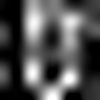

In [7]:
MSE = nn.MSELoss()

# seed: Array of 64 initial pixels
# target: number between 0-9
# output: Array of 64 modified pixels

def generate_digit(seed, target):
    image = seed.clone() # Copy so that examples from the dataset stay intact
    image.requires_grad = True # This is the important part
    image_optimizer = optim.Adam([image], lr=0.1) 
    
    #This is like doing epochs during training
    for step in range(200):
        #display_digit(image, index=step)
        image_optimizer.zero_grad()
        pred = model(torch.clamp(image, 0, 16)) # Clamp s.t. the domain stays the same
        loss = F.cross_entropy(pred, torch.tensor(target)) # Same loss as in training
        #loss += MSE(image, seed) * 2 # Generate adversarial images
        loss.backward()
        image_optimizer.step()
        
    return torch.clamp(image, 0, 16)
        

display_digit(generate_digit(X_tensor[0], 8))

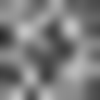

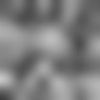

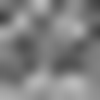

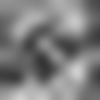

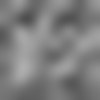

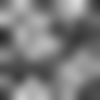

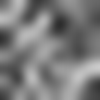

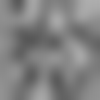

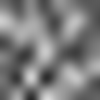

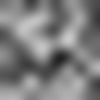

In [8]:
# Generate average images from noise
avg_nums = [np.mean(np.array([generate_digit(torch.rand(64) * 16, i).detach().numpy() for _ in range(100)]), axis=0) for i in range(10)]
for i, avg_num in enumerate(avg_nums):
    display_digit(avg_num, target_size=100, index=i)

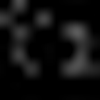

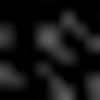

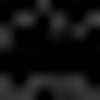

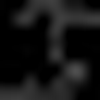

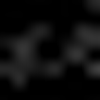

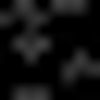

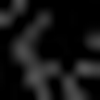

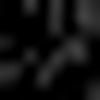

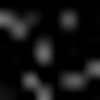

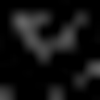

[None, None, None, None, None, None, None, None, None, None]

In [9]:
# Generate images from black squares
[display_digit(generate_digit(torch.zeros(64),i), index=i) for i in range(10)]